<a href="https://colab.research.google.com/github/Jj1802/Jumir-James-Japinan/blob/main/LabActivity1_Japinan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow basics

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/basics"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/basics.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/basics.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/basics.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This guide provides a quick overview of _TensorFlow basics_. Each section of this doc is an overview of a larger topic—you can find links to full guides at the end of each section.

TensorFlow is an end-to-end platform for machine learning. It supports the following:

* Multidimensional-array based numeric computation (similar to <a href="https://numpy.org/" class="external">NumPy</a>.)
* GPU and distributed processing
* Automatic differentiation
* Model construction, training, and export
* And more

## Training loops

Now put this all together to build a basic model and train it from scratch.

First, create some example data. This generates a cloud of points that loosely follows a quadratic curve:

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

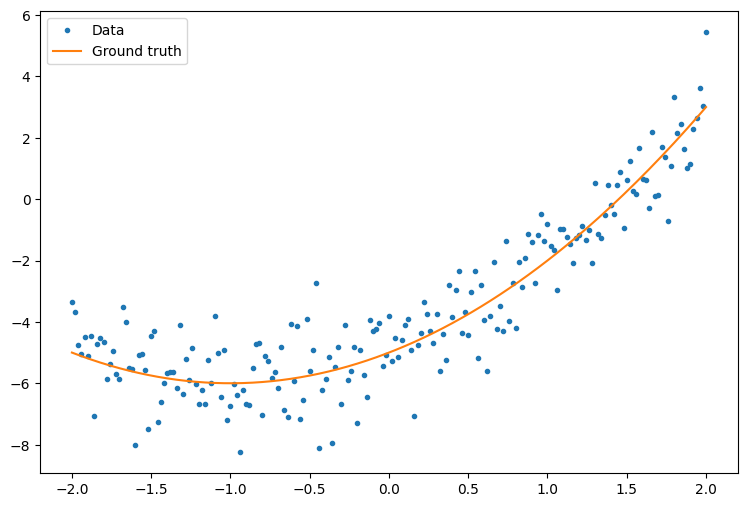

In [ ]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

Create a quadratic model with randomly initialized weights and a bias:

In [ ]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

First, observe your model's performance before training:

In [ ]:
quad_model = Model()

In [ ]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

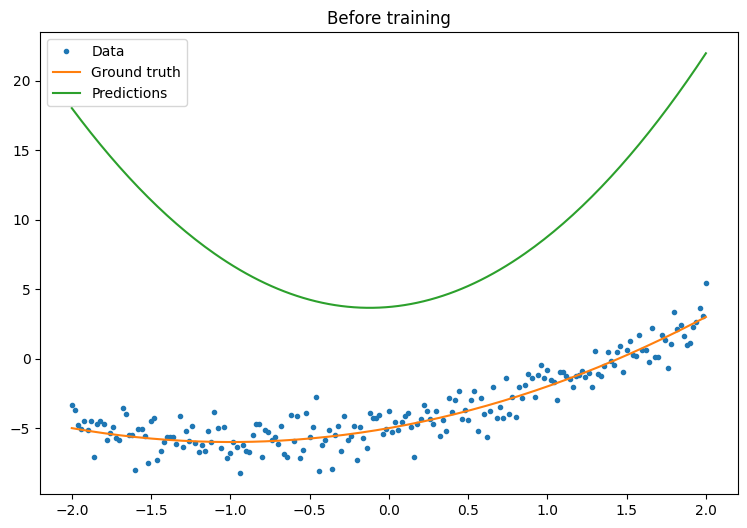

In [ ]:
plot_preds(x, y, f, quad_model, 'Before training')

Now, define a loss for your model:

Given that this model is intended to predict continuous values, the mean squared error (MSE) is a good choice for the loss function. Given a vector of predictions, $\hat{y}$, and a vector of true targets, $y$, the MSE is defined as the mean of the squared differences between the predicted values and the ground truth.

$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$

In [ ]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

Write a basic training loop for the model. The loop will make use of the MSE loss function and its gradients with respect to the input in order to iteratively update the model's parameters. Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 67.966
Mean squared error for step 10: 6.064
Mean squared error for step 20: 2.784
Mean squared error for step 30: 1.614
Mean squared error for step 40: 1.201
Mean squared error for step 50: 1.059
Mean squared error for step 60: 1.009
Mean squared error for step 70: 0.996
Mean squared error for step 80: 0.989
Mean squared error for step 90: 0.986




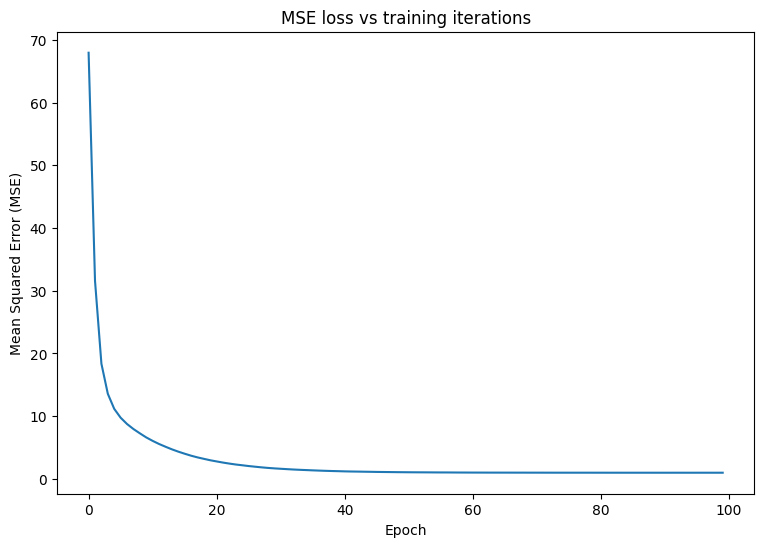

In [ ]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

Now, observe your model's performance after training:

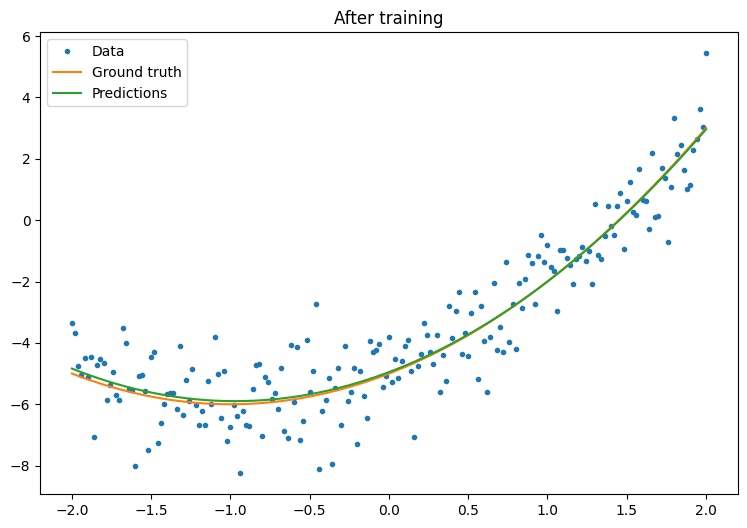

In [ ]:
plot_preds(x, y, f, quad_model, 'After training')

That's working, but remember that implementations of common training utilities are available in the `tf.keras` module. So, consider using those before writing your own. To start with, the `Model.compile` and `Model.fit` methods implement a training loop for you:

Begin by creating a Sequential Model in Keras using `tf.keras.Sequential`. One of the simplest Keras layers is the dense layer, which can be instantiated with `tf.keras.layers.Dense`. The dense layer is able to learn multidimensional linear relationships of the form $\mathrm{Y} = \mathrm{W}\mathrm{X} +  \vec{b}$. In order to learn a nonlinear equation of the form, $w_1x^2 + w_2x + b$, the dense layer's input should be a data matrix with $x^2$ and $x$ as features. The lambda layer, `tf.keras.layers.Lambda`, can be used to perform this stacking transformation.

In [ ]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

In [ ]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


Observe your Keras model's performance after training:

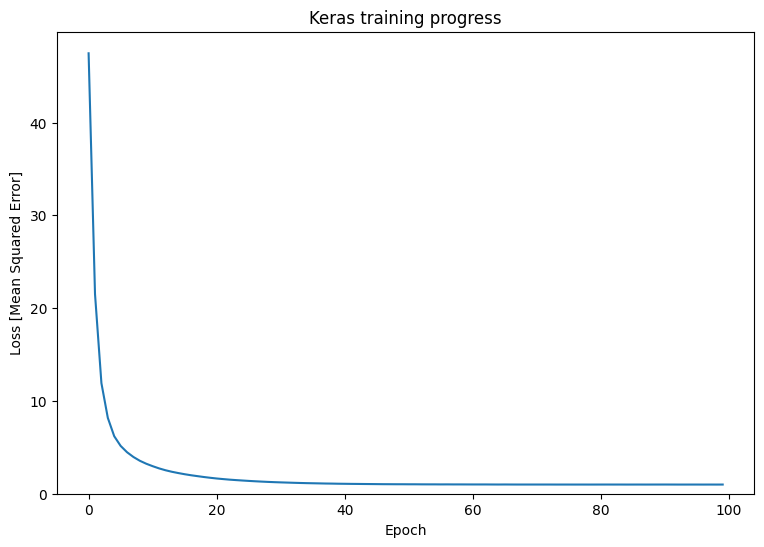

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

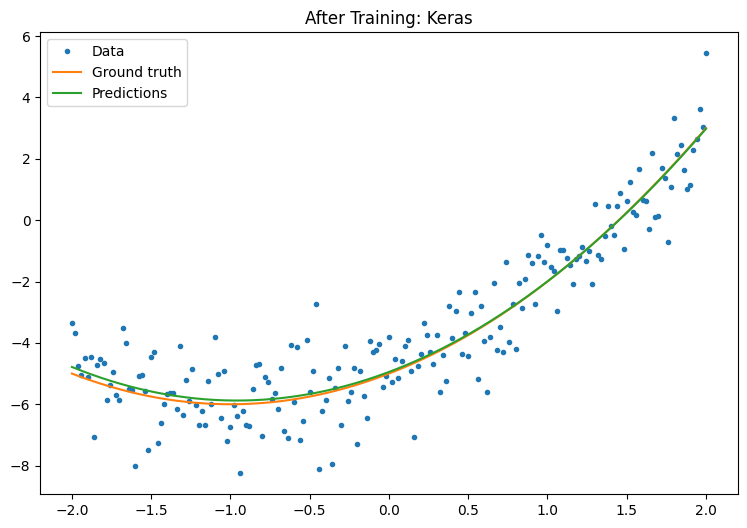

In [ ]:
plot_preds(x, y, f, new_model, 'After Training: Keras')

Refer to [Basic training loops](basic_training_loops.ipynb) and the [Keras guide](https://www.tensorflow.org/guide/keras) for more details.